In [1]:
import json
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

#### Set plot directory

In [5]:
plotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp\evoked_FR_plots'

Load CCF for identifying cortical areas

Load Zap_Zip-log_exp to get metadata for experiments

Load multisubject metadata .csv

In [6]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
0,psilocybin,657903,pilot_aw_psi_2023-01-13_12-18-22,"awake,psilocybin",deep,none,False,F:\psi_exp\mouse657903\pilot_aw_psi_2023-01-13...,25,"big lesion in CTX, stim closer to ORB anyway, ..."
1,psilocybin,666193,pilot_aw_psi_2023-02-16_10-55-48,psilocybin,deep,all,True,F:\psi_exp\mouse666193\pilot_aw_psi_2023-02-16...,25,no EEG
2,psilocybin,666194,pilot_aw_psi_2023-02-23_10-40-34,psilocybin,deep,none,True,F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23...,25,NaN
3,psilocybin,666196,pilot_aw_psi_2023-03-16_10-21-29,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,all,True,F:\psi_exp\mouse666196\pilot_aw_psi_2023-03-16...,25,EEG bad?
4,psilocybin,669118,pilot_aw_psi_2023-03-24_09-55-33,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,none,True,F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24...,25,"only has probe B, F"


#### Functions

In [7]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

### Choose subject to plot

In [8]:
subrow = subject_df.iloc[9]
print(subrow.mouse)

676727


In [9]:
exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical and sensory stimulation
aw_psi


#### Load stim table and add state label

In [10]:
## Load EEGexp and stim_log ##
exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

### Get all states in experiment ###
all_sweeps = np.unique(stim_log['sweep'].values)

## Get state label for each sweep ##
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
## Get depth label for each sweep ##
sweep_depth_list = []
for char in subrow.stim_depth.split(','):
    sweep_depth_list.append(char)
if len(sweep_depth_list) == 1:
    sweep_depth_list = sweep_depth_list * len(all_sweeps)
stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
## Get list of states and the middle current ##
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    ch_curr = str(currents[1])
else:
    ch_curr = str(currents[0])
    
print(states)

Experiment type: electrical and sensory stimulation
['awake' 'psilocybin']


In [11]:
print(currents)
print(ch_curr)

[40]
40


#### Load unit data

In [12]:
## Set FR time bin size ##
time_bin = 0.005 # s

## Set region unit threshold ##
unit_threshold = 5 # must have at least this number of units to be included in analysis

In [13]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))
#     continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3700,0.590620,AMv,248,177,193,other-TH
1,B1,probeB,0,3700,0.618090,AMv,248,177,193,other-TH
2,B5,probeB,1,3700,0.659296,AMv,248,177,192,other-TH
3,B7,probeB,1,3700,0.631826,AMv,248,177,192,other-TH
4,B8,probeB,1,3700,0.659296,AMv,248,177,192,other-TH


In [14]:
np.unique(unit_info['parent_region'].values)

array(['HIP', 'MO', 'OLF', 'ORB', 'PAL', 'PL', 'RHP', 'SM-TH', 'SS',
       'STR', 'VIS', 'other-TH'], dtype=object)

In [15]:
ROI_unit_info = {}
reg_ratio = []
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))
        reg_ratio.append(len(udf))

HIP: 195 units
MO: 86 units
OLF: 24 units
ORB: 364 units
PAL: 41 units
PL: 96 units
RHP: 21 units
SM-TH: 83 units
SS: 333 units
STR: 92 units
VIS: 151 units
other-TH: 165 units


### Get evoked FR

Get event inds

In [19]:
plstate = 'awake'
pltrials = 'running'

if pltrials == 'resting':
    trialbool = True
elif pltrials == 'running':
    trialbool = False

eventinds = stim_log[
    (stim_log['stim_type'] == 'biphasic') &
    (stim_log['parameter'] == ch_curr) &
    (stim_log['state'] == plstate) &
    (stim_log['resting_trial'] == trialbool) &
    (stim_log['good'] == True)
].index.values
print(len(eventinds))

107


Gather evoked z-scores

In [20]:
evokedFR = {}
evokedZ = {}
for regi, regdf in ROI_unit_info.items():
    unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan

    ## Get unit event spike times ##
    reg_unit_metrics = []
    for ii, unitrow in regdf.iterrows():
        unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in eventinds]
        ## Get firing rates ##    
        unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
        unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(eventinds))

    evokedFR[regi] = [timex, unit_firing_rates]
    evokedZ[regi] = [timex, get_zFR(unit_firing_rates, timex)]

### Plot

<IPython.core.display.Javascript object>


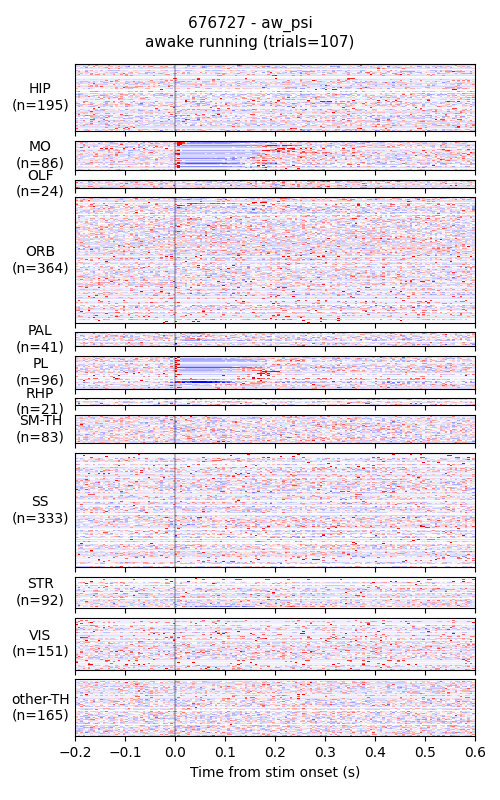

In [21]:
Zlim = 5
plwin = [-0.2, 0.6]

fig = plt.figure(figsize=(5, 8))
zaxs = fig.add_gridspec(
    ncols=1, nrows=len(reg_ratio), height_ratios=reg_ratio, left=0.15, right=0.95, top=0.92, bottom=0.08, hspace=0.2
).subplots(sharex=True)

for ii, (regi, regdf) in enumerate(ROI_unit_info.items()):
    imunit = zaxs[ii].imshow(
            evokedZ[regi][1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[evokedZ[regi][0][0], evokedZ[regi][0][-1], 0, evokedZ[regi][1].shape[1]],
        )
    zaxs[ii].axvline(0, color='k', alpha=0.25)
    zaxs[ii].set_ylabel('{}\n(n={:d})'.format(regi, evokedZ[regi][1].shape[1]), rotation=0, va='center', labelpad=25)
    zaxs[ii].set_yticks([])

zaxs[ii].set_xlim(plwin)
zaxs[ii].set_xlabel('Time from stim onset (s)')

fig.suptitle('{} - {}\n{} {} (trials={:d})'.format(exp.mouse, exp_tag, plstate, pltrials, len(eventinds)), fontsize=11)

## Save ##
figname = 'evokedZ_{}_{}_{}_allregions.png'.format(exp.mouse, exp_tag, pltrials)
fig.savefig(os.path.join(plotsavedir, figname), transparent=False, dpi=300)